In [1]:
import numpy as np
import os 
import re
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm


HP ClO_139 -0.15976160991999677


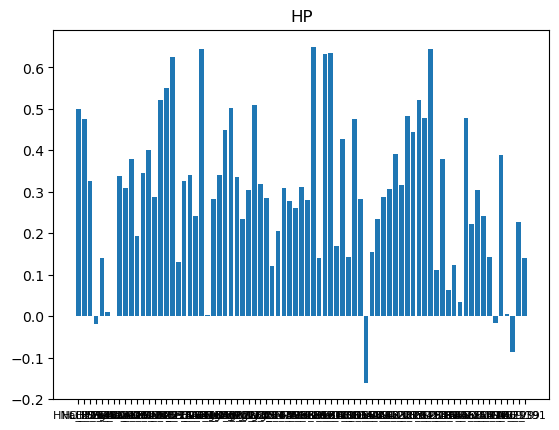

MgSi MgP_123 -0.10399571669995566
MgSi LiSi_123 -0.10688331630001358
MgSi AlSi_123 -0.10587919702004456


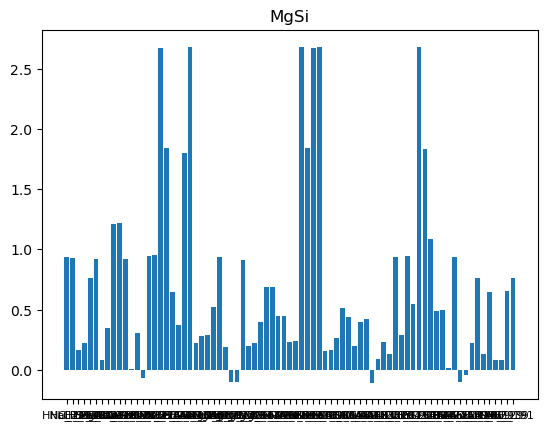

FMg HP_129 -0.13691654990020652
FMg FP_129 -0.1368252653401214
FMg ClP_129 -0.1364454098600163


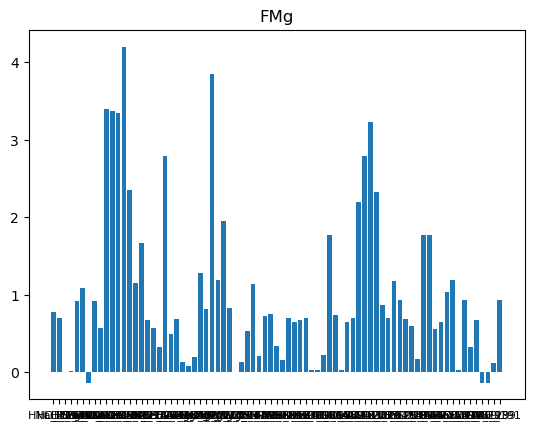

AlN HNa_225 -0.4408767773599891
AlN HLi_225 -0.29158388644000865
AlN HP_129 -0.4492764824599931
AlN FNa_225 -0.4462564334799879
AlN ClNa_225 -0.4364209767199725
AlN MgO_225 -0.4404289286800065
AlN MgS_225 -0.43175870563999297
AlN FLi_225 -0.4384727815199767
AlN FLi_194 -0.22899721650000515
AlN ClLi_225 -0.417092406480009
AlN ClLi_194 -0.2058233499600135
AlN PSi_225 -0.4463411675999964
AlN FP_129 -0.4501753289000021
AlN ClP_129 -0.4491926265600057


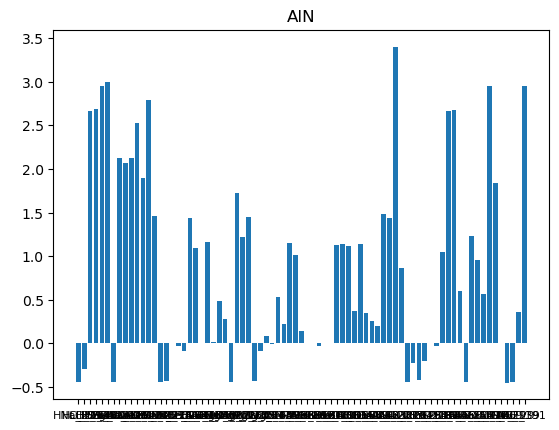

BeF BeF_166 -0.17142935761989975
BeF BeCl_166 -0.1128854648198967
BeF SSi_166 -0.14854658887986716


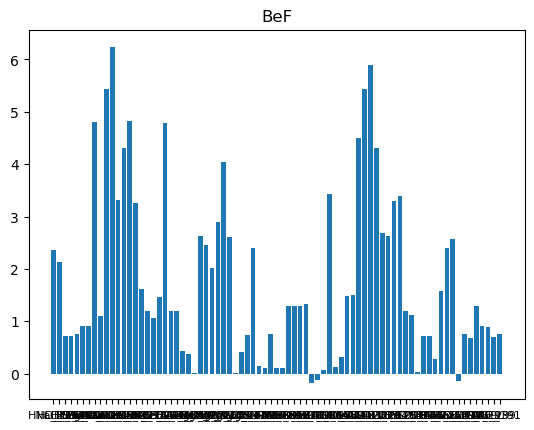

CS CF_164 -0.12852166191999004
CS CF_166 -0.19270509154000592


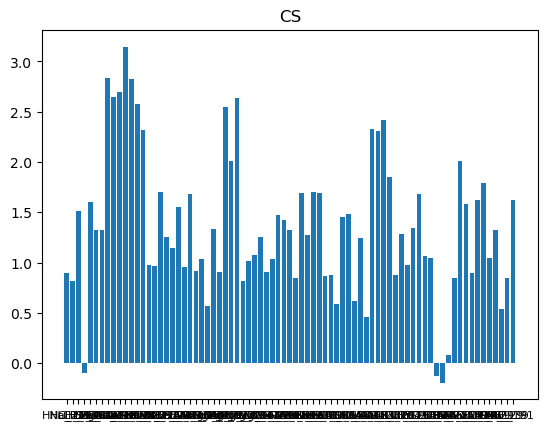

AlP HNa_225 -0.7649573422399953
AlP HLi_225 -0.7957194399599814
AlP CH_164 -0.2296734207399993
AlP CH_166 -0.25009701639999093
AlP HSi_191 -0.40227905935999786
AlP HSi_123 -0.10662027020001119
AlP HP_129 -0.7945084476799877
AlP MgNa_123 -0.6866473005599829
AlP LiNa_187 -0.5108340913999854
AlP LiNa_194 -0.541923179020003
AlP LiNa_123 -0.6966149159999873
AlP NaSi_123 -0.6889660230399954
AlP AlNa_141 -0.4839224756600089
AlP NaS_123 -0.6972680661999959
AlP FNa_225 -0.7652894657999951
AlP ClNa_225 -0.7319129564399844
AlP BBe_164 -0.16433503729999188
AlP BLi_166 -0.3904689040200111
AlP AlB_166 -0.42756484576000275
AlP AlB_156 -0.16300573929999018
AlP BS_166 -0.3958183684799792
AlP MgN_187 -0.5616165383200098
AlP MgO_225 -0.7649516914399896
AlP LiMg_123 -0.6894159287199955
AlP MgP_123 -0.7048070276400011
AlP AlMg_123 -0.6867706817999846
AlP MgS_225 -0.7318296231199923
AlP FMg_164 -0.44890940519999845
AlP ClMg_164 -0.41702506030000563
AlP NO_160 -0.3249451549599911
AlP LiN_139 -0.4912992802200

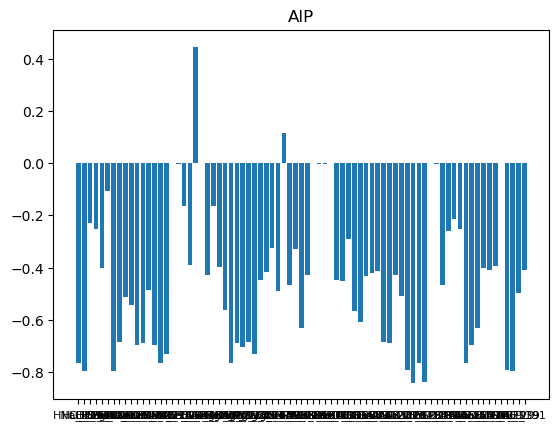

FP FSi_166 -0.1139889374266545


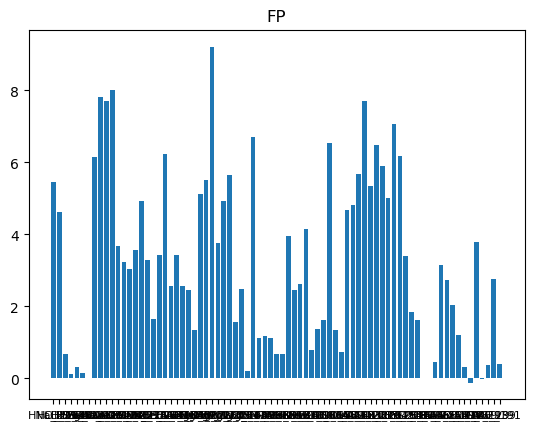

In [2]:
comp = 1
df_gs = pd.read_csv(f'./A{comp}B/relaxation/GroundStates.txt', header=None, na_filter=False)
df_temp = pd.read_csv(f'./A{comp}B/relaxation/RELAX_DATA', header=None, na_filter=False)
ticks_labels = []
for i in range(1,len(df_temp.columns)):
    ticks_labels.append(df_temp.loc[0,i])

for i in range(1,len(df_temp[0])):
    diff = np.zeros(len(df_temp.columns)-1)
    for j in range(1,len(df_temp.columns)):
        
        diff[j-1] = float(df_temp.loc[i,j])-float(df_gs[df_gs[0]==df_temp.loc[i,0]][1].values[0])
        if diff[j-1] < -0.1:
            print(df_temp.loc[i,0], ticks_labels[j-1], diff[j-1])
    if (min(diff) < -0.1):

        plt.bar(np.arange(1,len(df_temp.columns)), diff)
        plt.title(df_temp.loc[i,0])
        plt.xticks(np.arange(1,len(df_temp.columns)), ticks_labels, fontsize=8)
        plt.show()


# GRAFICI


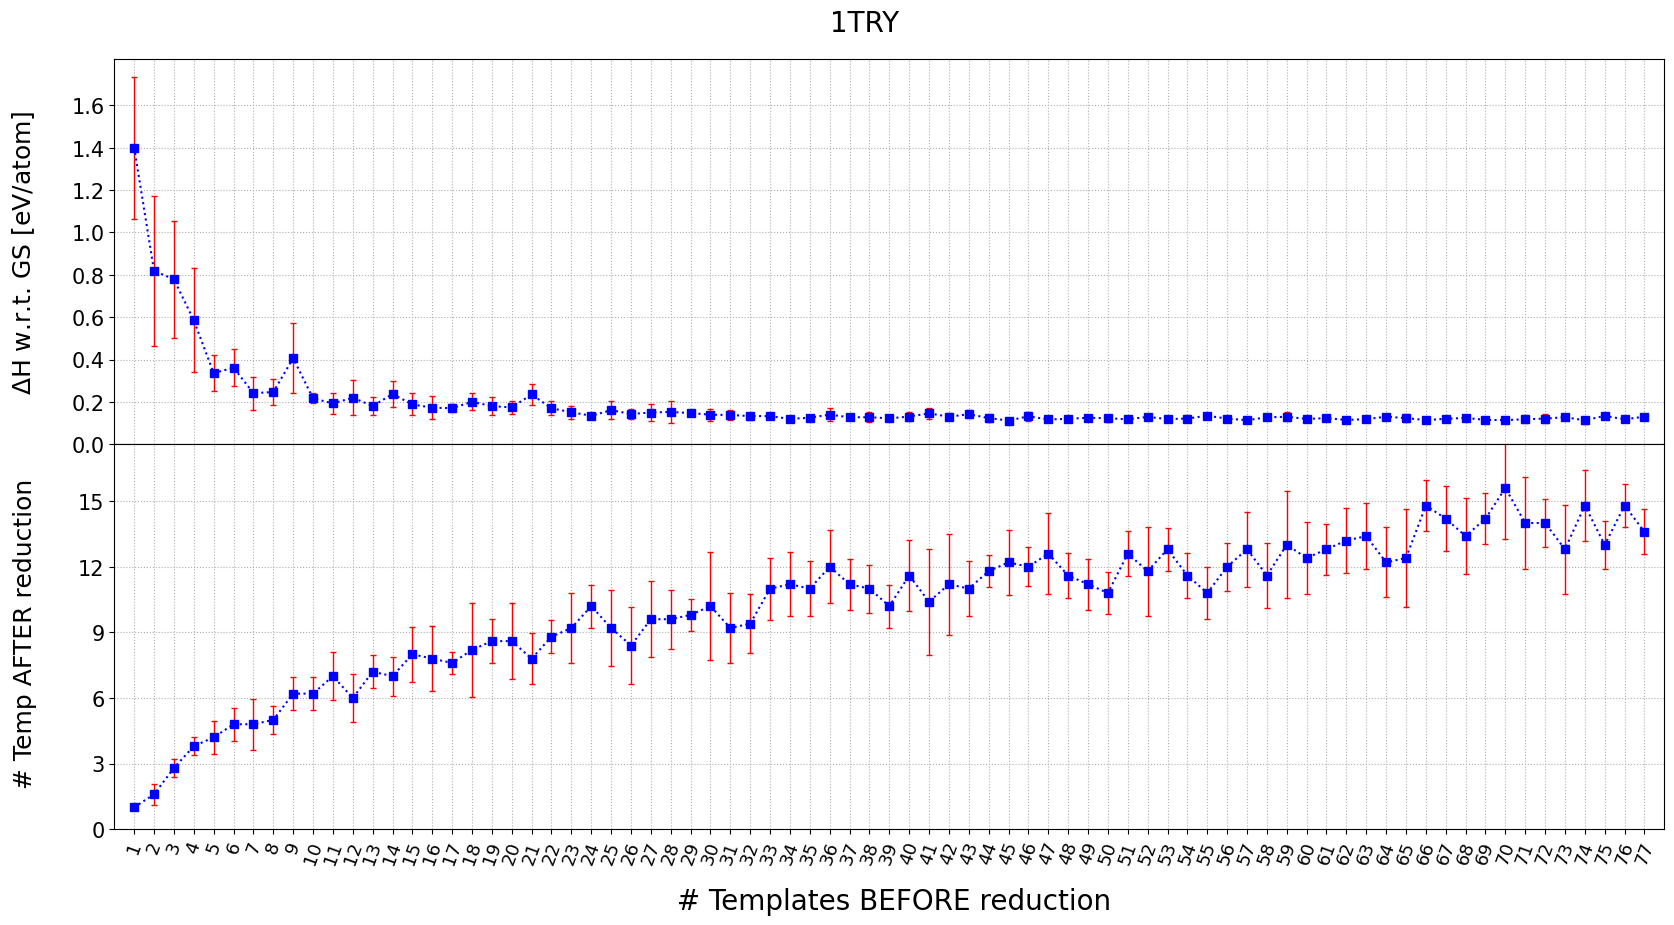

In [8]:
lista_titles = ['1TRY']
lista_dir = ['1TRY']
n_possible_couples = 105
n_sets = 5
for title_idx, dir_name in enumerate(lista_dir):

    df_stds = pd.read_csv(f'{dir_name}/StdsEveryCouple.csv', header=None, na_filter=False, index_col = 0)
    stds = df_stds.to_numpy()
    df_means = pd.read_csv(f'{dir_name}/MeansEveryCouple.csv', header=None, na_filter=False, index_col = 0)
    means = df_means.to_numpy()
    df_tot = pd.read_csv(f'{dir_name}/TotalStatics.csv', header=None, na_filter=False, index_col = 0)
    tot = (df_tot.to_numpy()).T
    df_numtemp = pd.read_csv(f'{dir_name}/NumberTempRedu.csv', header=None, na_filter = False, index_col = 0)
    numtemp = df_numtemp.to_numpy()

    other_std = np.zeros(len(df_stds[1]))

    x = np.arange(1, len(df_stds[1])+1) 

    for i in range(len(tot[0])):
        other_std[i] = (np.abs(means[i])).std()/np.sqrt(len(means[i]))


    title = lista_titles[title_idx]
    fig, (ax,ax1) = plt.subplots(2, 1, figsize=(20, 10), sharex=True)
    fig.subplots_adjust(hspace=0.0)
    fig.suptitle(title, fontsize=20, y=0.93)

    ax.errorbar(x, tot[0]/n_possible_couples, yerr=tot[1]/(n_possible_couples ), fmt='bs:', ecolor='red', elinewidth=1, capsize=2)
    #ax.errorbar(x, tot[0]/n_possible_couples, yerr=other_std, fmt='bs:', ecolor='black', elinewidth=1, capsize=2)

    ax.set_ylabel(r'$\Delta$H w.r.t. GS [eV/atom]', fontsize=18)
    ax.yaxis.set_label_coords(-0.05, 0.5)

    step = tot[0].max()/(n_possible_couples*10) *1.5
    step = np.round(step, decimals=1)
    y_ticks  = np.arange(0.0, tot[0].max()/n_possible_couples+tot[1].max()/(n_possible_couples), step)
    y_ticks = np.round(y_ticks, decimals=1)
    ax.set_yticks(y_ticks)
    ax.set_yticklabels(y_ticks, fontsize=15)
    ax.grid(True, ls=':')

    ax1.errorbar(x, numtemp[0], yerr=numtemp[1], fmt='bs:', ecolor='red', elinewidth=1, capsize=2)

    ax1.set_xlabel(' # Templates BEFORE reduction', fontsize=20)
    ax1.set_ylabel(' # Temp AFTER reduction', fontsize=18)
    ax1.xaxis.set_label_coords(0.5, -0.15)
    ax1.yaxis.set_label_coords(-0.05, 0.5)

    ax1.set_xticks(x)
    ax1.set_xlim(0, x.max()+1)
    ax1.set_xticklabels(x, fontsize=13, rotation=70)
    ax1.set_ylim(0,numtemp[0].max()+2)

    step = numtemp[0].max()/5
    step = np.round(step)
    y_ticks  = np.arange(0,numtemp[0].max()+1,step)
    y_ticks = np.rint(y_ticks)
    y_ticks = y_ticks.astype(int)
    ax1.set_yticks(y_ticks)
    ax1.set_yticklabels(y_ticks, fontsize=15)
    ax1.grid(True, ls=':')


    plt.show()

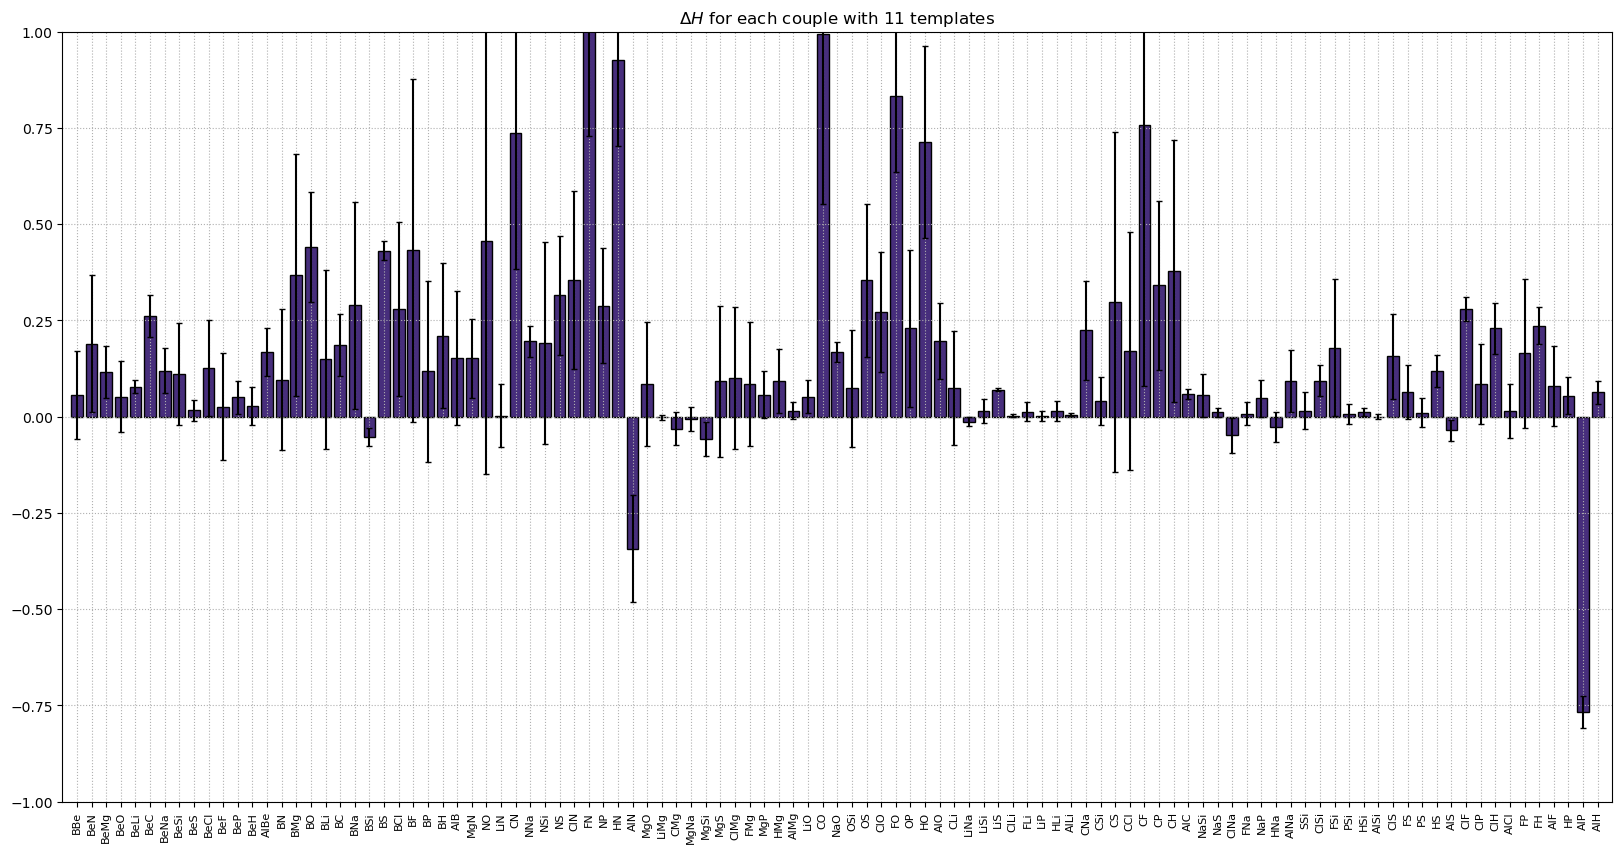

In [4]:
test_elements=['Be', 'B', 'N', 'Mg', 'O', 'Li', 'C', 'Na', 'Si', 'S', 'Cl', 'F', 'P', 'H', 'Al']
tlabels = []
count = 0
comp = 1
if comp == 1:
    tlabels = []
    for i in range(len(test_elements)):
        for j in range(i+1,len(test_elements)):
            couple = [test_elements[i], test_elements[j]]
            couple.sort()
            tlabels.append(couple[0]+couple[1])
else:
    for k in range(len(test_elements)):
        for l in range(len(test_elements)):
            if k == l:
                continue
            count += 1
            cp = [test_elements[k], test_elements[l]]
            tlabels.append(cp[0]+cp[1])
                    
for i in range(10,11):
    fig, ax1 = plt.subplots(1,1, figsize=(20, 10))
    color_value = cm.viridis(i/len(df_stds[1]))
    ax1.set_title(r'$\Delta H$ for each couple with '+f'{i+1} templates')
    ax1.grid(linestyle=':')

    ax1.bar(np.arange(len(tlabels)), means[i], yerr=stds[i], color=color_value, edgecolor='black', capsize=2)
    ax1.set_xticks(np.arange(len(tlabels)))
    ax1.set_xticklabels(tlabels, fontsize=8, rotation = 90)
    ax1.set_xlim(-1,len(tlabels))

    ax1.set_ylim(-1,1)
    plt.show()

# JSON2CSV

In [9]:
import json
import os
import pandas as pd
import re

with open('A1B/relaxation/ent.json') as f:
    data = json.load(f)

columns = []
rows = []
for key in data['1'].keys():
    rows.append(key)
    for k in data['1'][key].keys():
        name = re.search(r'([A-Za-z]*)(\d+)', k).group(1)
        sg = re.search(r'([A-Za-z]*)(\d+)', k).group(2)
        if f'{name}_{sg}' not in columns:
            columns.append(f'{name}_{sg}')
    
df = pd.DataFrame(index=rows ,columns=columns)

for key in data['1'].keys():
    for k in data['1'][key].keys():
        name = re.search(r'([A-Za-z]*)(\d+)', k).group(1)
        sg = re.search(r'([A-Za-z]*)(\d+)', k).group(2)
        df.loc[key, f'{name}_{sg}'] = data['1'][key][k]

df.to_csv('A1B/relaxation/RELAX_DATA')
with open('A1B/relaxation/RELAX_DATA', 'r') as f:
    lines = f.readlines()
lines[0] = 'COUPLES' + lines[0]
with open('A1B/relaxation/RELAX_DATA', 'w') as f:
    f.writelines(lines)
